In [1]:
#general libraries
import numpy as np
import pandas as pd
import sys
import os
from collections import defaultdict
from joblib import memory
import warnings
warnings.filterwarnings(action='ignore')

#general expression
import re

#libraries for merging multiple dataframe
from functools import reduce

#math formula
import math

#sampling 
from imblearn.over_sampling import  *

#metrics for performance of models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

#classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor,MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest

#decompose
from sklearn.decomposition import PCA

#encoding
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


#sql

import csv
from io import StringIO

from sqlalchemy import create_engine





Using TensorFlow backend.


In [9]:
cdir=r'C:\Users\user\Desktop\data\brazil'
order_review=pd.read_csv(os.path.join(cdir,'olist_order_reviews_dataset.csv'))
customer_data=pd.read_csv(os.path.join(cdir,'olist_customers_dataset.csv'))
geolocation_data=pd.read_csv(os.path.join(cdir,'olist_geolocation_dataset.csv'))
order_items=pd.read_csv(os.path.join(cdir,'olist_order_items_dataset.csv'))
order_payments=pd.read_csv(os.path.join(cdir,'olist_order_payments_dataset.csv'))
order_data=pd.read_csv(os.path.join(cdir,'olist_orders_dataset.csv'))
product_data=pd.read_csv(os.path.join(cdir,'olist_products_dataset.csv'))
seller_data=pd.read_csv(os.path.join(cdir,'olist_sellers_dataset.csv'))
product_category=pd.read_csv(os.path.join(cdir,'product_category_name_translation.csv'))

# 1. Preprocessing The Data

### 1.1  Product Information

First,we should translate the name of each product into Enlgish.This can be easily done with the help fo the extra information provided by Kaggle website.

In [3]:
#create the dictionries contining the product categories both in Portuguese and English
names={br:en for br,en in zip(product_category.product_category_name,product_category.product_category_name_english)}
product_data.product_category_name=product_data.product_category_name.map(lambda x: names[x] if x in names.keys() else np.nan)

In [4]:
product_data.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0


### 1.2 Tables Related to The Infomration of Orders


> - _order_review_ : review_id,order_id,review_score,and review_commnet_message are only included in our data anyalysis
To explore the particular pattern of consumers in our dataset, we will exclude some columns which do not help out.Dates for the review and its response would not be a part of explaining unless extra information on the review date is available. Therfore,we should put it aside for a while.
>
>
> - _order_payment_sequential_ : all features are included
>
>
>- _order_data_ : We expect a lot of hidden or latent factors in these features, which help us better retrieve the pattern of consumers.We also include all the factors in this dataset
>
>
>- _order_item_ : A majority of the columns in this dataset will lead us to see the basic information on shippment of products including the price of freight, the price of product_value and so on.  
>
>
> Finally,we ill join the multiples dataframes we go through and if you look into the datasets carefully,they all have the common column called order_id.





In [5]:
df=[order_review[['review_id','order_id','review_score','review_comment_message']],order_payments,order_data,order_items]
#reduce only is used for either Dataframe or Sereis
order_data=reduce(lambda left,right:pd.merge(left,right,on='order_id'),df)

In [6]:
id_columns=list()
others=list()

p=re.compile('_id')
for col in order_data.columns:
    m=p.search(col)
    if m:
        id_columns.append(col)
    else:
        others.append(col)
new_columns=id_columns+others

In [7]:
order_data=order_data.reindex(columns=new_columns)
order_data.head()

,review_id,order_id,customer_id,order_item_id,product_id,seller_id,review_score,review_comment_message,payment_sequential,payment_type,...,payment_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,41dcb106f807e993532d446263290104,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,4,NaN,1,credit_card,...,397.26,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,2018-01-18 15:47:59,185.00,13.63
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,41dcb106f807e993532d446263290104,2,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,4,NaN,1,credit_card,...,397.26,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,2018-01-18 15:47:59,185.00,13.63
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,8a2e7ef9053dea531e4dc76bd6d853e6,1,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,5,NaN,1,credit_card,...,88.09,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00,2018-03-06 12:48:39,79.79,8.30
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,e226dfed6544df5b7b87a48208690feb,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,5,NaN,1,credit_card,...,194.12,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00,2018-02-08 10:31:15,149.00,45.12
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,de6dff97e5f1ba84a3cd9a3bc97df5f6,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,5,Recebi bem antes do prazo estipulado.,1,credit_card,...,222.84,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00,2017-04-13 17:55:19,179.99,42.85


### 1.3  Information on Address of Consumers and Sellers

<img src='https://user-images.githubusercontent.com/53164959/83901918-764e5700-a796-11ea-9598-4421d8339912.png' style='width:400px;height:200px'>

Every infomration seems to be valuable and useful for our upcoming analysis and exclusion of any features would be highly unnecessary.However, 
the column that could be referenced to join three tables(ie customer_data,seller_data,and geolocation_data) have different names. We need to change them to a single name,simply 'zip_code_prefix'. Let's demonstrate the code for relabeling the names.


In [101]:
#change columns containg 'zip_code_prefix'
def rename(names):
    names=list(names)
    p=re.compile('zip_code_prefix*')
    for index,name in enumerate(names):
        m=p.search(name)
        if m:
            names[index]=name[m.start():]
    return names

In [102]:
customer_data.columns=rename(customer_data.columns)
geolocation_data.columns=rename(geolocation_data.columns)
seller_data.columns=rename(seller_data.columns)

In [103]:
print(customer_data.columns)
print(seller_data.columns)
print(geolocation_data.columns)

Index(['customer_id', 'customer_unique_id', 'zip_code_prefix', 'customer_city',
       'customer_state'],
      dtype='object')
Index(['seller_id', 'zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')
Index(['zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')


In [104]:
customer_data.head()

,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


### 1.4 Relabeling ID 

>In our datasets, we will encounter a lot of ID labelings that help to uniquely identify each row.  However, the combinations of letters and numbers are quite lengthy and not recognizable. We better come out with new labelings for readability and avoidance of memory waste.
All the records in any columns containing _id  are now being converted into a simple format, the combination of column name and unique integer number, which helps to correctly identify them.
>
>For example, 7bc2406110b926393aa56f80a40eba40 in the review column changes to 'revew_id_1'.

In [105]:
order_data.head()

,review_id,order_id,customer_id,order_item_id,product_id,seller_id,review_score,review_comment_message,payment_sequential,payment_type,...,payment_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,41dcb106f807e993532d446263290104,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,4,NaN,1,credit_card,...,397.26,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,2018-01-18 15:47:59,185.00,13.63
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,41dcb106f807e993532d446263290104,2,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,4,NaN,1,credit_card,...,397.26,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,2018-01-18 15:47:59,185.00,13.63
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,8a2e7ef9053dea531e4dc76bd6d853e6,1,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,5,NaN,1,credit_card,...,88.09,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00,2018-03-06 12:48:39,79.79,8.30
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,e226dfed6544df5b7b87a48208690feb,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,5,NaN,1,credit_card,...,194.12,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00,2018-02-08 10:31:15,149.00,45.12
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,de6dff97e5f1ba84a3cd9a3bc97df5f6,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,5,Recebi bem antes do prazo estipulado.,1,credit_card,...,222.84,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00,2017-04-13 17:55:19,179.99,42.85


In [106]:
def relabel(data,column):
    label=defaultdict(int)
    j=1
    s=list()
    for index,value in enumerate(data[column]):
        if value not in label:
            label[value]=j
            e=column+'-'+str(j)
            s.append(e)
            j+=1
        else:
            e=column+'-'+str(label[value])
            s.append(e)
    return s,label

columns=['review_id','order_id','customer_id','product_id','seller_id']
def get_relabel(data,columns):
    dicts_id=dict()
    for column in columns:
        result,dict_id=relabel(data,column)
        dicts_id[column]=dict_id
        data[column]=data[column].map(lambda x:column+'_'+str(dict_id[x]))
    return dicts_id

#relabel order_data
labels=get_relabel(order_data,columns)
#relabel product_data
product_data.product_id=product_data.product_id.map(lambda x: 'product_id_'+str(labels['product_id'][x]))
#relabel seller_data
seller_data.seller_id=seller_data.seller_id.map(lambda x: 'seller_id_'+str(labels['seller_id'][x]))
#customer_data
customer_data.customer_id=customer_data.customer_id.map(lambda x:'customer_id_'+str(labels['customer_id'][x]))
#add customer_unique_id to the labels
results,unique_id=relabel(customer_data,'customer_unique_id')
labels.update({'customer_unique_id':unique_id})
customer_data.customer_unique_id=results

In [107]:
#Now,we check if all of the corresponding columns are correctly converted
display(product_data.head())
display(order_data.head())
display(customer_data.head())
display(seller_data.head())

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,product_id_13592,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,product_id_32830,art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,product_id_14506,sports_leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,product_id_26080,baby,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,product_id_5593,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0


,review_id,order_id,customer_id,order_item_id,product_id,seller_id,review_score,review_comment_message,payment_sequential,payment_type,...,payment_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value
0,review_id_1,order_id_1,customer_id_1,1,product_id_1,seller_id_1,4,NaN,1,credit_card,...,397.26,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,2018-01-18 15:47:59,185.00,13.63
1,review_id_1,order_id_1,customer_id_1,2,product_id_1,seller_id_1,4,NaN,1,credit_card,...,397.26,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,2018-01-18 15:47:59,185.00,13.63
2,review_id_2,order_id_2,customer_id_2,1,product_id_2,seller_id_2,5,NaN,1,credit_card,...,88.09,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00,2018-03-06 12:48:39,79.79,8.30
3,review_id_3,order_id_3,customer_id_3,1,product_id_3,seller_id_3,5,NaN,1,credit_card,...,194.12,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00,2018-02-08 10:31:15,149.00,45.12
4,review_id_4,order_id_4,customer_id_4,1,product_id_4,seller_id_3,5,Recebi bem antes do prazo estipulado.,1,credit_card,...,222.84,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00,2017-04-13 17:55:19,179.99,42.85


,customer_id,customer_unique_id,zip_code_prefix,customer_city,customer_state
0,customer_id_24280,customer_unique_id-1,14409,franca,SP
1,customer_id_67257,customer_unique_id-2,9790,sao bernardo do campo,SP
2,customer_id_43668,customer_unique_id-3,1151,sao paulo,SP
3,customer_id_71444,customer_unique_id-4,8775,mogi das cruzes,SP
4,customer_id_31609,customer_unique_id-5,13056,campinas,SP


,seller_id,zip_code_prefix,seller_city,seller_state
0,seller_id_2710,13023,campinas,SP
1,seller_id_804,13844,mogi guacu,SP
2,seller_id_1350,20031,rio de janeiro,RJ
3,seller_id_1023,4195,sao paulo,SP
4,seller_id_1762,12914,braganca paulista,SP


### 1.4(Removing Duplicated Entries)

In this section,we wil take various approaches to deal with missing data. Before procedding to the further stages, we need to merge
the given data on product_id. Right after conslidation, you will see there are duplicate entries avaiable in the merged table. We can obtain distinct values of the dataframe based on two columns; customer_id and   'order_purchase_timestamp'


In [127]:
merged=pd.merge(product_data,order_data,on='product_id')
merged=pd.merge(merged,customer_data,on='customer_id')
merged.drop(['zip_code_prefix','customer_city','customer_state'],axis=1,inplace=True)


print(f'The Number of Rows Before Removing Duplicated Entries:  {len(merged)}')
print('-'*100)
merged=merged.drop_duplicates(subset=["customer_id","order_purchase_timestamp",'customer_unique_id'])
print(f'The Num of Rows with Distinct Values:  {len(merged)}')


The Number of Rows Before Removing Duplicated Entries:  118315
----------------------------------------------------------------------------------------------------
The Num of Rows with Distinct Values:  98665


## 1.5 Missing Data
### 1.5.1 Imputation : Categorical Data 


My algorithm to impute the missing values of categorical data is as follows:

>1) Select an entry with missing information and search for the seller of the product 
>
>2) If the seller has a variety of products displayed in the dataset, we choose one of them based on the similarity in the distance >of a vector with a missing category name to one with the label.
>
>3)If the seller is only selling one type and the product is unlabeled. Now that the product has no comparison to make, we just >simply name it 'missing category'.

The calculation of the distance between two vectors is done with euclidean distance. Before running the above algorithm,we need to merge antother data including seller related information  since the product_data does not hold any information reagarding sellers.

In [128]:
r_columns=['product_id','seller_id','product_category_name','product_weight_g','product_length_cm','product_height_cm','product_width_cm']
tests=merged[merged.product_category_name.isnull()][r_columns]
missing_product=dict()

def distance(a,b):
    results=[math.sqrt(value) for value in np.sum((a-b)**2,axis=1)]
    index=np.argmin(results)
    return index

for a in tests.values:
    try:
        a=np.array(a)
        if a[0] not in missing_product:
            missing_product[a[0]]={'seller_id':a[1],'cv':np.array(a[3:])}
        df=merged[~(merged.product_category_name.isnull())&(merged.seller_id==a[1])][r_columns]
        temp=np.array(df.values[:,3:])
        base=missing_product[a[0]]['cv']
        index=distance(temp,base)
        missing_product[a[0]]['product_category_name']=df.values[index][2]
    except:
        missing_product[a[0]]['product_category_name']='missing_category'
        
t=merged[merged.product_category_name.isnull()]['product_id'].map(lambda x:missing_product[x]['product_category_name'])
merged.product_category_name=merged.product_category_name.fillna(t)

In [72]:
# see product_category_name has change to zero
merged.product_category_name
product_category_name=merged.product_category_name

mem =memory.Memory(cachedir='/cache')
merged.to_csv('/cache/merged_data.csv')

## 1.5.2 Imputation : Continuous Variable

### 1)  imputing the missing values in physical attributes of products : part 1
         

In [309]:
merged=pd.read_csv('/cache/merged_data.csv')
display(merged.isnull().sum())
null_columns=['product_category_name','seller_id','product_photos_qty','product_length_cm','product_height_cm','product_width_cm']


Unnamed: 0                           0
product_id                           0
product_category_name                0
product_name_lenght                  0
product_description_lenght           0
product_photos_qty                   0
product_weight_g                    16
product_length_cm                   16
product_height_cm                   16
product_width_cm                    16
review_id                            0
order_id                             0
customer_id                          0
order_item_id                        0
seller_id                            0
review_score                         0
review_comment_message           57653
payment_sequential                   0
payment_type                         0
payment_installments                 0
payment_value                        0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_customer_date        0
order_estimated_delivery_

Out of 16 missing entries, the one whose product category belongs to 'baby'  has a lack of comparison since after tracking down the seller-id as you can see below.  We will fill the missing part with the mean values of all the entries of the baby category.

The rest of them comes from a single seller who might have forgotten to fill in the specification of physical information to the product. In this case, It should be possible for us to replace those values with the median of counterparts in the same industry.

In [310]:
#Lack of comparision since we only have one comparision to impute
missing_index=26370
missing_columns=['product_weight_g','product_length_cm','product_height_cm','product_width_cm']

#impute each missing feature with the average values
result=merged[merged.product_category_name=='baby'][missing_columns].transform(lambda x:x.fillna(x.mean()))
merged.loc[missing_index,missing_columns]=result.loc[missing_index,:]


#find the index of missing data whose product category belongs to computer_accessories
incomplete_data_index=merged[merged.product_length_cm.isnull()].index
columns=missing_columns+['price','review_score']
#imputing the medais based on group median
X=merged[(merged.product_category_name=='computers_accessories')&(merged.price==29)|(merged.price==39)][columns].groupby(['price','review_score'])
labels=['product_weight_g','product_length_cm','product_height_cm','product_width_cm']
merged.loc[incomplete_data_index,labels]=X.transform(lambda x:x.median()).loc[incomplete_data_index,labels]

print(merged.isnull().sum())

Unnamed: 0                           0
product_id                           0
product_category_name                0
product_name_lenght                  0
product_description_lenght           0
product_photos_qty                   0
product_weight_g                     0
product_length_cm                    0
product_height_cm                    0
product_width_cm                     0
review_id                            0
order_id                             0
customer_id                          0
order_item_id                        0
seller_id                            0
review_score                         0
review_comment_message           57653
payment_sequential                   0
payment_type                         0
payment_installments                 0
payment_value                        0
order_status                         0
order_purchase_timestamp             0
order_approved_at                    0
order_delivered_customer_date        0
order_estimated_delivery_

### 2)  imputing the missing values : part 2 ( Implementing Poission Regression in R)

Our attention now goes to the rest of the columns with missing data. They are all directly related to the description of products. To predict these count variables,  Poisson regression model is the best choice we could take. Let's implement a regression and see what the summary of the result is telling us.


```R
require(sandwich)
require(msm)

data=read.csv('C:/Users/user/Desktop/data/brazil/merged.csv')
head(data)
data=data[,2:10]
attach(data)
labels(data)[2]
#remove any data with na
complete=na.omit(data)
ml=glm(product_photos_qty~product_weight_g+product_length_cm+product_height_cm+product_width_cm
       +price+freight_value+review_score,data=data,family="poisson")
summary(ml)

cov.ml=vcovHC(ml,type="HC0")
std.err=sqrt(diag(cov.ml))
r.est=cbind(Estimate= coef(ml), "Robust SE" = std.err,
               "Pr(>|z|)" = 2 * pnorm(abs(coef(m1)/std.err), lower.tail=FALSE),
               LL = coef(ml) - 1.96 * std.err,
               UL = coef(ml) + 1.96 * std.err)
r.est
```
>#### Do not heavily rely on p-value! Look at the confidence interval and interpret the coefficient values wisely!

![image](https://user-images.githubusercontent.com/53164959/85456148-9f197d80-b5d9-11ea-97de-d92dae11b81a.png)|

There is a tendency for the p-value to get closer to zero in the case where the data size is relatively big.  It is highly recommendable to prepare the confidence interval for each coefficient and interpret it wisely. 
As we expect, all of the coefficient values are extremely lower and even closer to zero with p-value telling us that all but freight value are significant factors. This conflict encourages us to decide not to go further.
 The expected log count for a one-unit increase in the 'relevant' factor is 0, which indicates the variable is not contributing to the explanation about the variability of the response.
 


### 3)  imputing the missing values : part 4 



In [311]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

from scipy.stats import pearsonr
from scipy import stats

merged.columns

Index(['Unnamed: 0', 'product_id', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'review_id', 'order_id',
       'customer_id', 'order_item_id', 'seller_id', 'review_score',
       'review_comment_message', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'shipping_limit_date', 'price', 'freight_value', 'customer_unique_id'],
      dtype='object')

In [312]:
complete=merged[~(merged.product_description_lenght.isnull())]
complete.drop(['Unnamed: 0', 'product_id','customer_id', 'order_item_id', 'seller_id','review_comment_message','payment_installments', 'payment_value', 'order_status',
       'order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date','order_estimated_delivery_date', 'shipping_limit_date','freight_value', 'customer_unique_id','review_id', 'order_id'],axis=1,inplace=True)

In [313]:
y=complete['product_description_lenght']
X=complete
X.produt_description_length=np.nan
ct=ColumnTransformer(
    [('numeric','passthrough',['product_weight_g','product_length_cm','product_height_cm','product_width_cm','price']),
     ('categorical',OrdinalEncoder(),['product_description_lenght','product_category_name','payment_type','review_score'])],
    remainder='drop')
X=ct.fit_transform(complete)


#implement Iterative Imputer
#imputer=IterativeImputer(missing_values=np.nan,add_indicator=True,n_nearest_features=2,sample_posterior=True,initial_strategy='median')
imputer=KNNImputer(missing_values=np.nan)
X_filled=imputer.fit_transform(X)
X_filled=pd.DataFrame(X_filled,columns=['product_weight_g','product_length_cm','product_height_cm','product_width_cm','price','product_description_lenght','product_category_name','payment_type','review_score'])

#to see how close predict values and real observations are.
def pearsonStatics(obs,pred,alpha=0.05):
    r,p=pearsonr(obs,pred)
    r_z=np.arctanh(r)
    #compute standard error
    se=1/np.sqrt(len(y)-3)
    z=stats.norm.pdf(1-alpha/2)
    lo_z,hi_z=r_z-z*se,r_z+z*se
    
    lo,hi=np.tanh((lo_z,hi_z))
    tables=[r,p,lo,hi]
    results=pd.Series(tables,index=['Correlation','p-value','low','high'])
    print(results)
pearsonStatics(X_filled.product_description_lenght,y)

Correlation    0.981356
p-value        0.000000
low            0.981327
high           0.981385
dtype: float64


We have taken pearsons stastics for measuring the performance. It is resonable to believe that two sets(predictions and observed values) are approximately close to each other.Let's impute the missing and take the same steps for the rest of them. I have tried out another imputation technique which is called K-Nearest neighbors and the end result is pretty much the same as we have seen in this section. 

In [314]:
columns=['product_name_lenght', 'product_description_lenght','product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm','price','product_category_name']

temp=merged.copy()
Ol=OrdinalEncoder()
encoded=Ol.fit_transform(temp.product_category_name.values.reshape(-1,1))
temp.product_category_name=encoded

#imputing the values 
X_filled=imputer.fit_transform(temp.loc[:,columns])

#ovewriting the values to the original dataset
merged.loc[:,['product_name_lenght', 'product_description_lenght','product_photos_qty']]=X_filled[:,:3]

In [315]:
for col in ['product_name_lenght', 'product_description_lenght','product_photos_qty']:
    merged.loc[:,col]=np.around(merged.loc[:,col])


### 4)  imputing the missing values : part 4 (Timestamp data)

As for the dates of transactiona and delivery, we will only consider order date, order_approved_dates,order_customer_date. 
If the status of order is currenltly shipped,there would be missing values either or both in the last two dates.

In [317]:
#imputing date a customer recieve producst with estimate one if it is missing
result=merged.loc[merged.order_delivered_customer_date.isnull(),'order_estimated_delivery_date']
merged.loc[merged.order_delivered_customer_date.isnull(),'order_delivered_customer_date']=result

#Convert all the date columns to datetime unit
columns=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date',
       'order_estimated_delivery_date']
merged.loc[:,columns]=merged.loc[:,columns].astype('datetime64[ns]')

In [318]:
#find the average of time interval between pruchase time and order_approved
#impute missing values with the average
temp=merged.order_approved_at-merged.order_purchase_timestamp
avg_seconds=np.nanmean(temp.dt.seconds)
merged.loc[merged.order_approved_at.isnull(),'order_approved_at']=merged.loc[merged.order_approved_at.isnull(),'order_purchase_timestamp']+pd.DateOffset(seconds=avg_seconds) 


### 1.5.3 Outliers


### 1.5.3.1 Outliers Detection

In [319]:
try:
    merged.drop('Unnamed: 0',inplace=True,axis=1)
except:
    pass


After displaying the scatter plots of multiple input features, the size of outliers should vary from one to another. If you take a closer look at the different scatter plots against price, we can detect extreme values that are distinct from aggregated points. There may be due to variability in measurements or may indicate errors. Since we are dealing with the metastasizing of data in our hands, it seems to be somehow impossible to plot an individual feature against another for outliers detection for many times. Instead, we should run various machine learning algorithms, hoping that they could correctly identify them. 

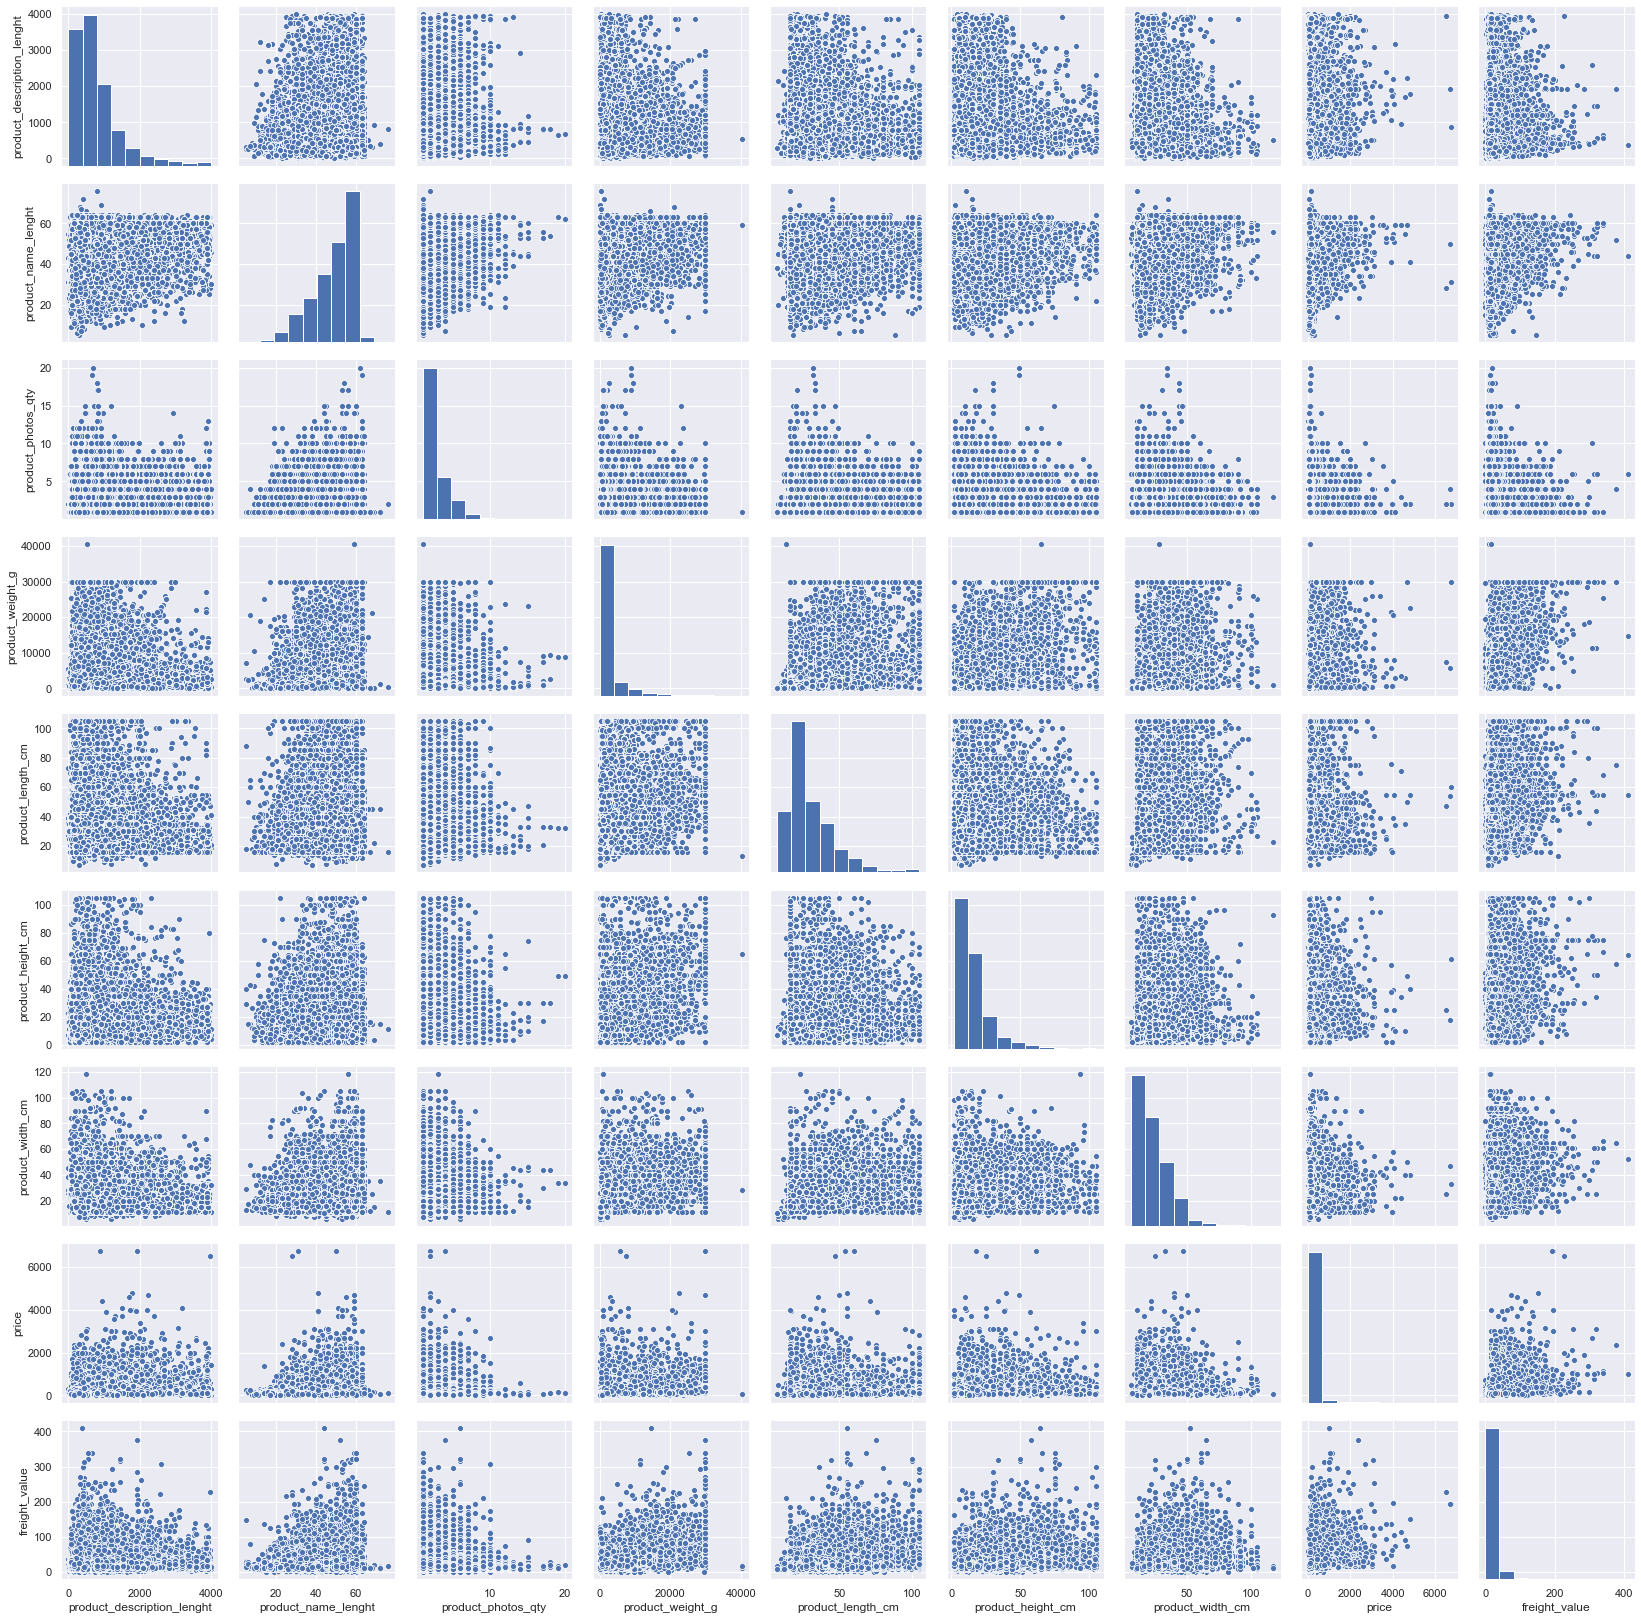

In [320]:
import seaborn as sns
columns=['product_description_lenght', 'product_name_lenght','product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'price', 'freight_value']
sns.pairplot(merged.loc[:,columns])

In [335]:
columns=['product_description_lenght', 'product_name_lenght','product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'price', 'freight_value']

s=merged.loc[:,columns]

clf=IsolationForest(n_estimators=100,max_samples=0.25,contamination=0.005,n_jobs=-1,random_state=10)

In [336]:
pred=clf.fit_predict(s)
s['annomaly_isolationForest']=np.nan
s['annomaly_isolationForest']=pred
outlier_index=s.annomaly_isolationForest[s.annomaly_isolationForest==-1].index

In [337]:
s.annomaly_isolationForest.value_counts()

 1    98171
-1      494
Name: annomaly_isolationForest, dtype: int64

In [338]:
sc=StandardScaler()
s_stand=sc.fit_transform(s.loc[:,:'freight_value'])
pca=PCA(n_components=5)
s_pca=pca.fit_transform(s_stand)


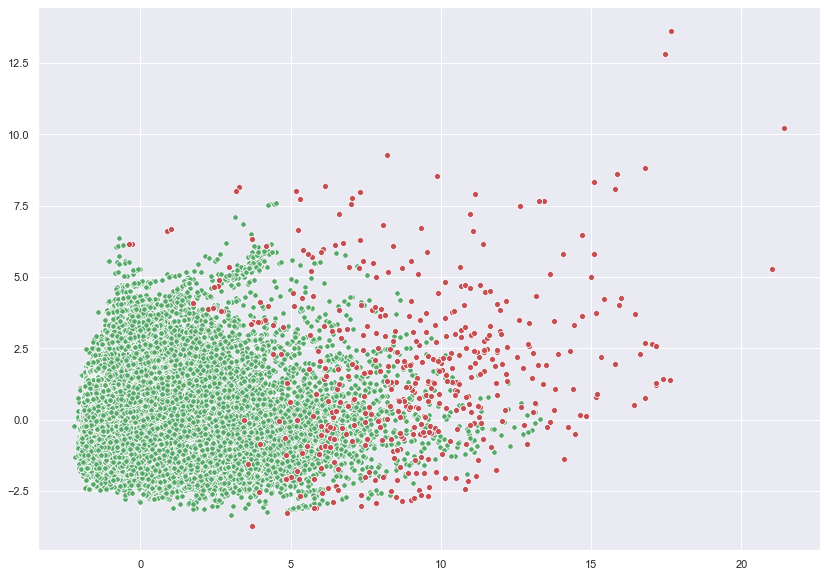

In [339]:
import matplotlib.pyplot as plt 
sns.set()
fig,ax=plt.subplots(figsize=(14,10))
sns.scatterplot(s_pca[:,0],s_pca[:,1],color='g',s=30,ax=ax)
sns.scatterplot(s_pca[outlier_index,0],s_pca[outlier_index,1],color='r')

In [340]:
s=merged.loc[:,columns].copy()
y=merged.loc[:,'freight_value']

In [291]:
count_variables=['product_description_lenght', 'product_name_lenght','product_photos_qty']
for col in count_variables:
    dummies=pd.get_dummies(s[col],prefix=col,prefix_sep='_')
    s=pd.concat([s,dummies],axis=1)

s.drop(count_variables,axis=1,inplace=True)

In [354]:
normal_index=np.arange(len(s))
normal_index=np.delete(normal_index,outlier_index)
truncated_data=merged.loc[normal_index,:]
truncated_data.to_csv('/cache/truncated_data.csv')

### 1.6 Assigning Upper Class to Eeach Product Name 

In [2]:
data=pd.read_csv('/cache/truncated_data.csv')

In [3]:
# supplies,persona
categories={'perfumery':'luxuary',
             'art':'supplies',
             'sports_leisure':'fashion',
             'baby':'health_baby_care', 
             'housewares':'appliances',
             'musical_instruments':'instruments',
             'cool_stuff':'entertainment',
            'furniture_decor':'home_kitchen',
            'home_appliances':'appliances', 
            'toys':'entertainment', 
            'bed_bath_table':'furnishing',
            'construction_tools_safety':'tool_material', 
            'computers_accessories':'technology',
            'health_beauty':'health_baby_care',
            'luggage_accessories':'fashion', 
            'garden_tools':'tool_material',
            'office_furniture':'furnishing',
            'auto':'extra_category', 
            'electronics':'technology', 
            'fashion_shoes':'fashion',
            'telephony':'technology',
            'stationery':'supplies', 
            'fashion_bags_accessories':'fashion', 
            'computers':'technology',
            'home_construction':'tool_material',
            'watches_gifts':'luxuary',
            'construction_tools_construction':'tool_material', 
            'pet_shop':'extra_category', 
            'small_appliances':'appliances',
            'agro_industry_and_commerce':'agriculture', 
            'furniture_living_room':'furnishing',
            'signaling_and_security':'technology',
            'air_conditioning':'technology', 
            'consoles_games':'entertainment',
            'books_general_interest':'entertainment', 
            'costruction_tools_tools':'tool_material',
            'fashion_underwear_beach':'fashion', 
            'fashion_male_clothing':'fashion',
            'kitchen_dining_laundry_garden_furniture':'furnishing',
            'industry_commerce_and_business':'extra_category', 
            'fixed_telephony':'technology',
            'construction_tools_lights':'tool_material', 
            'books_technical':'entertainment',
            'home_appliances_2':'appliances', 
            'party_supplies':'supplies', 
            'drinks':'food_beverage', 
            'market_place':'extra_category',
            'la_cuisine':'food_beverage', 
            'missing_category':'extra_category', 
            'costruction_tools_garden':'tool_material',
            'fashio_female_clothing':'fashion', 
            'home_confort':'home_kitchen', 
            'audio':'entertainment', 
            'food_drink':'food_beverage',
            'music':'entertainment', 
            'food':'food_beverage', 
            'tablets_printing_image':'home_kitchen', 
            'books_imported':'entertainment',
            'small_appliances_home_oven_and_coffee':'appliances', 
            'fashion_sport':'fashion',
            'christmas_supplies':'supplies', 
            'fashion_childrens_clothes':'fashion', 
            'dvds_blu_ray':'entertainment',
            'arts_and_craftmanship':'extra_category',
            'extra':'extra_category', 
            'furniture_bedroom':'home_kitchen', 
            'cine_photo':'entertainment',
            'diapers_and_hygiene':'health_baby_care', 
            'flowers':'home_kitchen', 
            'home_comfort_2':'home_kitchen',
            'security_and_services':'technology', 
            'furniture_mattress_and_upholstery':'furnishing',
            'cds_dvds_musicals':'entertainment'}

In [6]:
#create the upper class 
data.main_category=np.nan
data['main_category']=data.product_category_name.map(lambda x:categories[x])
data.to_csv('/cache/truncated_data.csv')

In [6]:
for key,value in categories.items():
    if value=='personal_item':
        print(key)

perfumery
cool_stuff
watches_gifts
cine_photo


array(['delivered', 'canceled', 'shipped', 'invoiced', 'processing',
       'unavailable', 'approved'], dtype=object)

### 1.5.3.1 Outliers Managment (Auto Variational Encoder)

In [292]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [293]:
from sklearn.preprocessing import MinMaxScaler

X=MinMaxScaler().fit_transform(s)
y=y.values

In [73]:
np.random.seed=50
tf.random.set_seed(50)
K=tf.keras.backend
tf.keras.backend.clear_session()
latent_dim=1

In [294]:
normal_index=np.arange(len(s))
normal_index=np.delete(normal_index,outlier_index)

X_normal=X[normal_index,:]
X_outlier=X[outlier_index,:]
y_normal=y[normal_index]
y_outlier=y[outlier_index]

In [295]:
def fit_batchsize(X,y,batch_size):
    n_size = (len(X)//batch_size)*batch_size
    X = X[0:n_size]
    y = y[0:n_size]
    return X, y

In [296]:
X_train,X_val,y_train,y_val=train_test_split(X_normal,y_normal,test_size=int(len(X)*0.7))
X_val,X_test,y_val,y_test=train_test_split(X_val,y_val,test_size=int(len(X_val)*0.5))

In [297]:
X_train,X_val,y_train,y_val=train_test_split(X_normal,y_normal,test_size=0.7)
X_val,X_test,y_val,y_Test=train_test_split(X_val,y_val,test_size=0.5)

In [298]:
batch_size=32
X_train,y_train=fit_batchsize(X_train,y_train,batch_size)
X_val,y_val=fit_batchsize(X_val,y_val,batch_size)
X_test,y_test=fit_batchsize(X_test,y_test,batch_size)

In [350]:
np.random.seed = 50
tf.random.set_seed(50)
K=keras.backend
keras.backend.clear_session()
input_dim=X_train.shape[1]
latent_dim = 1
inputs =layers.Input(shape=(input_dim,))
z = keras.layers.Dense(256, activation='relu')(inputs)
z = keras.layers.Dropout(0.1)(z)
z = keras.layers.Dense(128, activation='relu')(z)
z = keras.layers.Dropout(0.1)(z)
z = keras.layers.Dense(32, activation='relu')(z)
z = keras.layers.Dense(16, activation='relu')(z)
latent_mean = keras.layers.Dense(latent_dim)(z)
latent_log_var = keras.layers.Dense(latent_dim)(z)

encoder=Model(inputs,latent_mean)

def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2)* eps


z = layers.Lambda(sample_z, name='sampleZ',output_shape=(latent_dim,))([latent_mean,latent_log_var])

x = layers.Dense(16, activation='relu')(z)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
outputs=layers.Dense(input_dim, activation='tanh')(x)

vae=Model(inputs,outputs)
latent_loss = -0.5 * K.sum(1 + latent_log_var - K.exp(latent_log_var) - K.square(latent_mean),axis=-1)
vae.add_loss(K.mean(latent_loss)/(input_dim*1.))
vae.compile(loss='mse',optimizer=keras.optimizers.Adam(learning_rate=0.1),metrics=['mse'])

In [351]:
vae.fit(X_train,y_train,epochs=10,validation_data=(X_val,y_val),callbacks=[keras.callbacks.EarlyStopping(monitor='loss',patience = 3)])

Epoch 1/10
915/915 [==============================] - 10s 11ms/step - loss: 503.8815 - mse: 503.8813 - val_loss: 513.4462 - val_mse: 513.4462
Epoch 2/10
915/915 [==============================] - 10s 11ms/step - loss: 503.8337 - mse: 503.8337 - val_loss: 513.4462 - val_mse: 513.4462
Epoch 3/10
915/915 [==============================] - 10s 11ms/step - loss: 503.8331 - mse: 503.8331 - val_loss: 513.4462 - val_mse: 513.4462
Epoch 4/10
915/915 [==============================] - 10s 11ms/step - loss: 503.8333 - mse: 503.8333 - val_loss: 513.4462 - val_mse: 513.4462
Epoch 5/10
915/915 [==============================] - 11s 12ms/step - loss: 503.8333 - mse: 503.8333 - val_loss: 513.4462 - val_mse: 513.4462
Epoch 6/10
291/915 [========>.....................] - ETA: 4s - loss: 528.0040 - mse: 528.0040

KeyboardInterrupt: 

In [326]:
connect()

## 1.6 Outliers